In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker 
from matplotlib.patches import Rectangle

#Stuff for Meteorological calculations 
import wrf
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

#Next thing: we need to know open up every file in the Dean Directory and loop through them!
import glob
import pandas as pd

In [2]:
#Function Below is for a storm following map projection. Credit: Dr. Sharanya Majumdar @The University of Miami
dataproj = ccrs.PlateCarree()

def create_map_background(tclon,tclat):

    tclon5a=5*(int(tclon/5)-1)
    tclon5b=5*(int(tclon/5))
    tclat5a=5*(int(tclat/5)-1)
    tclat5b=5*(int(tclat/5))
     
    #Specify plot size
    fig=plt.figure(figsize=(15, 15))
    ax=plt.subplot(111, projection=dataproj)
    
    #specify boundary extent from TC center. Current specifications give us a 10° x 10° projection
    ax.set_extent([tclon-5, tclon+5, tclat-5, tclat+5],ccrs.PlateCarree()) #Constrain FOV of plot
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True)
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a-10, tclon5a-5, tclon5a, tclon5b, tclon5b+5, tclon5b+10])
    gl.ylocator = mticker.FixedLocator([tclat5a-10, tclat5a-5, tclat5a, tclat5b, tclat5b+5, tclat5b+10])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES)
    return fig, ax

In [3]:
#New Color Scale for IR Brightness
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

#Creating IR color Scale
def make_Ramp( ramp_colors ):
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ["#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e",
                          "#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e",
                          "#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074",
                          "#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080",
                          "#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b",
                          "#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093",
                          "#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097",
                          "#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b",
                          "#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d",
                          "#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d",
                          "#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c",
                          "#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b",
                          "#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198",
                          "#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395",
                          "#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692",
                          "#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b",
                          "#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681",
                          "#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72",
                          "#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60",
                          "#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444",
                          "#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23",
                          "#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913",
                          "#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a",
                          "#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05",
                          "#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603",
                          "#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01",
                          "#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800",
                          "#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400",
                          "#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00",
                          "#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600",
                          "#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300",
                          "#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00",
                          "#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900",
                          "#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400",
                          "#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02",
                          "#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b",
                          "#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b",
                          "#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635",
                          "#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57",
                          "#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280",
                          "#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa",
                          "#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd",
                          "#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee",
                          "#fffef1","#fffef4","#fffff6"]) 

top = custom_ramp
bottom = cm.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0,1,66)), 
                     bottom(np.linspace(0, 1, 33))))

newcmp = ListedColormap(newcolors, name = 'Cam_Cool_Color_Scale')

In [4]:
#the unadjusted domain has 9 more files than the adjusted run due to our lovely HPC
Parent_wrfout_unadjusted_d02 = sorted(glob.glob('/Users/cjmasiel/Desktop/unadjusted/wrfout_d02*'))

#for most purposes, this code below is useless but it is there anyways in case you need to adjust your file size
Parent_wrfout_unadjusted_d02 = Parent_wrfout_unadjusted_d02[:-9]

In [5]:
#first, we are going to calculate the pressure center for our center following plots

tc_lon = []                                             #Empty List for TC center longitude
tc_lat = []                                             #Empty List for TC center latitude


#Start looking for pressure minimum in WRF out files
#for i in range(len(Parent_wrfout_unadjusted_d02)):
for i in range(0,1):
    wrf_out_data = xr.open_dataset(Parent_wrfout_unadjusted_d02[i])          #Open WRF_Out Data (I sorted glob glob my whole directory)

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Now, to find the location of the lowest surface pressure pertubation
    minpressure = np.min(surface_P_pertubation[:,:])
    minp = minpressure.values

    #Now we know what the lowest pressure is, we have to find the index value for where it occurs
    da = surface_P_pertubation
    p_index = np.argwhere(da.where(da == minp,0).values)
    s_n = p_index[0][0]
    w_e = p_index[0][1]

    #Append lat and longitude centers into a list for plotting
    lon = wrf_out_data['XLONG'][0,s_n,w_e].values
    tc_lon.append(lon)
    lat = wrf_out_data['XLAT'][0,s_n,w_e].values
    tc_lat.append(lat)

In [6]:
#Specify how many grid cells away from the above lat-long pair you want your box to extend. 
#I have a 4km domain, so I specify 10 here giving me a 400 x 400km area average sounding. Can increase or decrease
#This value for a smaller or larger box!

Extent_of_Box = 50


In [7]:
X_Y_Sounding_Center = []

#now we need to get the x_y points of each lat longitude coordinate
#for i in range(len(Parent_wrfout_unadjusted_d02)):
for i in range(0,1):
    file = Parent_wrfout_unadjusted_d02[i]
    wrfin = Dataset(str(file))
    x_ycenter = wrf.ll_to_xy(wrfin, tc_lat[i], tc_lon[i])
    X_Y_Sounding_Center.append(x_ycenter)

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


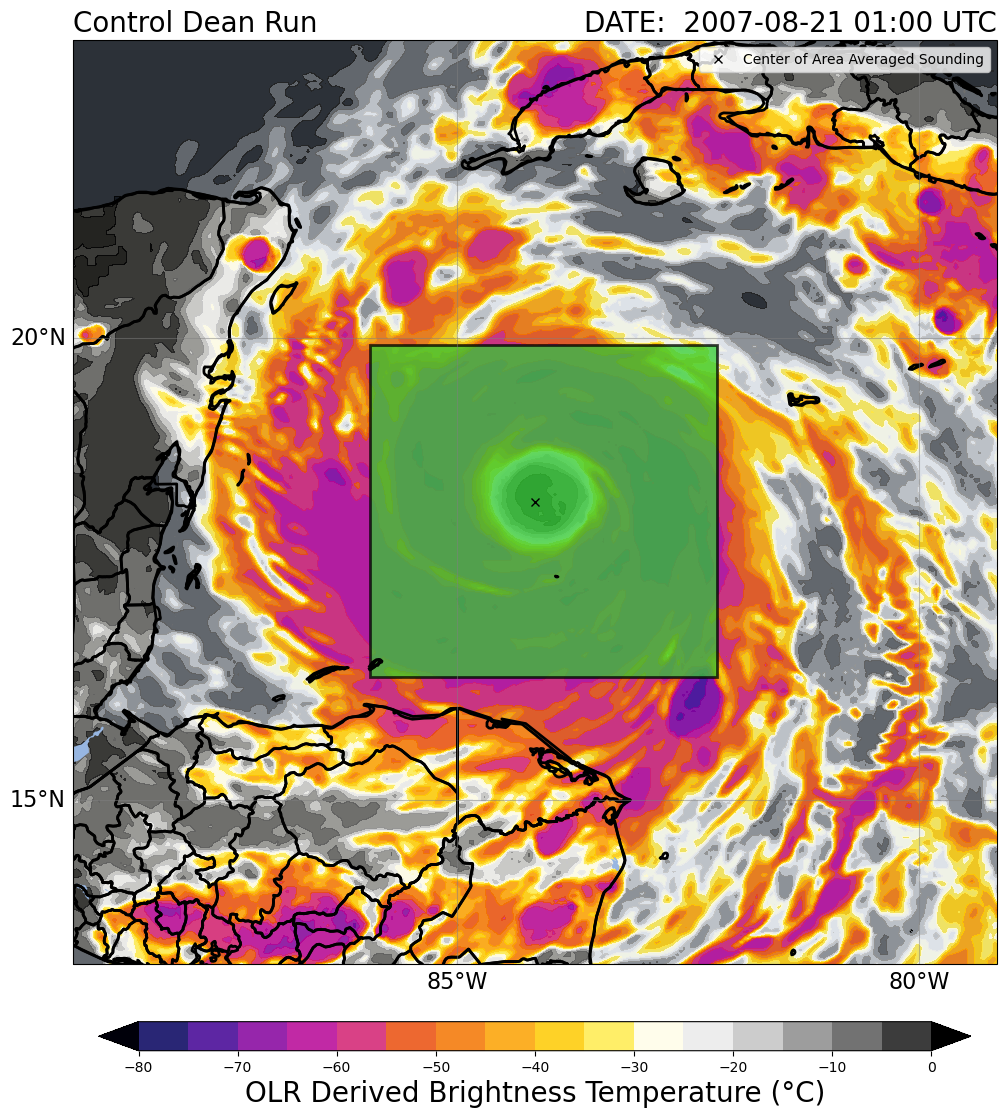

In [8]:
#constant Needed for Calcualtions
sigma = 5.67 * 10**-8                           #Stefon-Boltzman Constant

#compare sounding location to IR brightness to make sure it is in the correct location
#for i in range(len(Parent_wrfout_unadjusted_d02)):
for i in range(0,1):
    wrf_out_data = xr.open_dataset(Parent_wrfout_unadjusted_d02[i])          #Open WRF_Out Data (I sorted glob glob my whole directory)
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_EMISS = wrf_out_data['EMISS'][0,:,:]
    
    wrf_out_OLR_T = ((wrf_out_OLR.values/(wrf_out_EMISS.values * sigma))**(1/4)) - 273.15
    
    ncfile = Dataset(Parent_wrfout_unadjusted_d02[i])
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr = (str(Time))
    
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])

    #Plot OLR Data
    fig, ax = create_map_background(tc_lon[i],tc_lat[i]) #We are only looking at 11 indices, and our list goes from 0-11, not 24 and up

    plot = plt.contourf(wrf_out_data['XLONG'][0,:,:].values, wrf_out_data['XLAT'][0,:,:].values, wrf_out_OLR_T,
            origin = 'lower', cmap = newcmp, levels = np.arange(-80, 5, 5), alpha = .85, extend ='both')

    cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_xlabel('OLR Derived Brightness Temperature (°C)', fontsize = 20)
 
    #For Sounding Location
    lon_i = wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1],X_Y_Sounding_Center[i][0]].values
    lat_i = wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1],X_Y_Sounding_Center[i][0]].values

    plt.plot(lon_i, lat_i, "x", color = 'black', label = "Center of Area Averaged Sounding")


    #Add square for where we are attempting to take an area average sounding!
    #bottom Left Point of Square:
    bottom_left = (wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values, 
                  wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values)
        
    width = (wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]+Extent_of_Box].values - 
            wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values)
    
    height = (wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1]+Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values - 
             wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values)
    
    ax.add_patch(Rectangle((bottom_left), #bottom left point of square
                 width,                   #Width
                 height,                  #height
                 edgecolor = 'black',
                 facecolor = 'limegreen',
                 fill= True, alpha = .75,
                 lw=2))


    #Add Coastlines
    ax.coastlines('50m', linewidth=2)
    ax.add_feature(cfeature.STATES, linewidth=2)
    ax.add_feature(cfeature.BORDERS, linewidth=2)

    plt.title(f'DATE: '+' '+titletime+' UTC', loc = 'right', fontsize = 20)
    plt.title('Control Dean Run', loc = 'left', fontsize = 20)
    plt.legend()

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


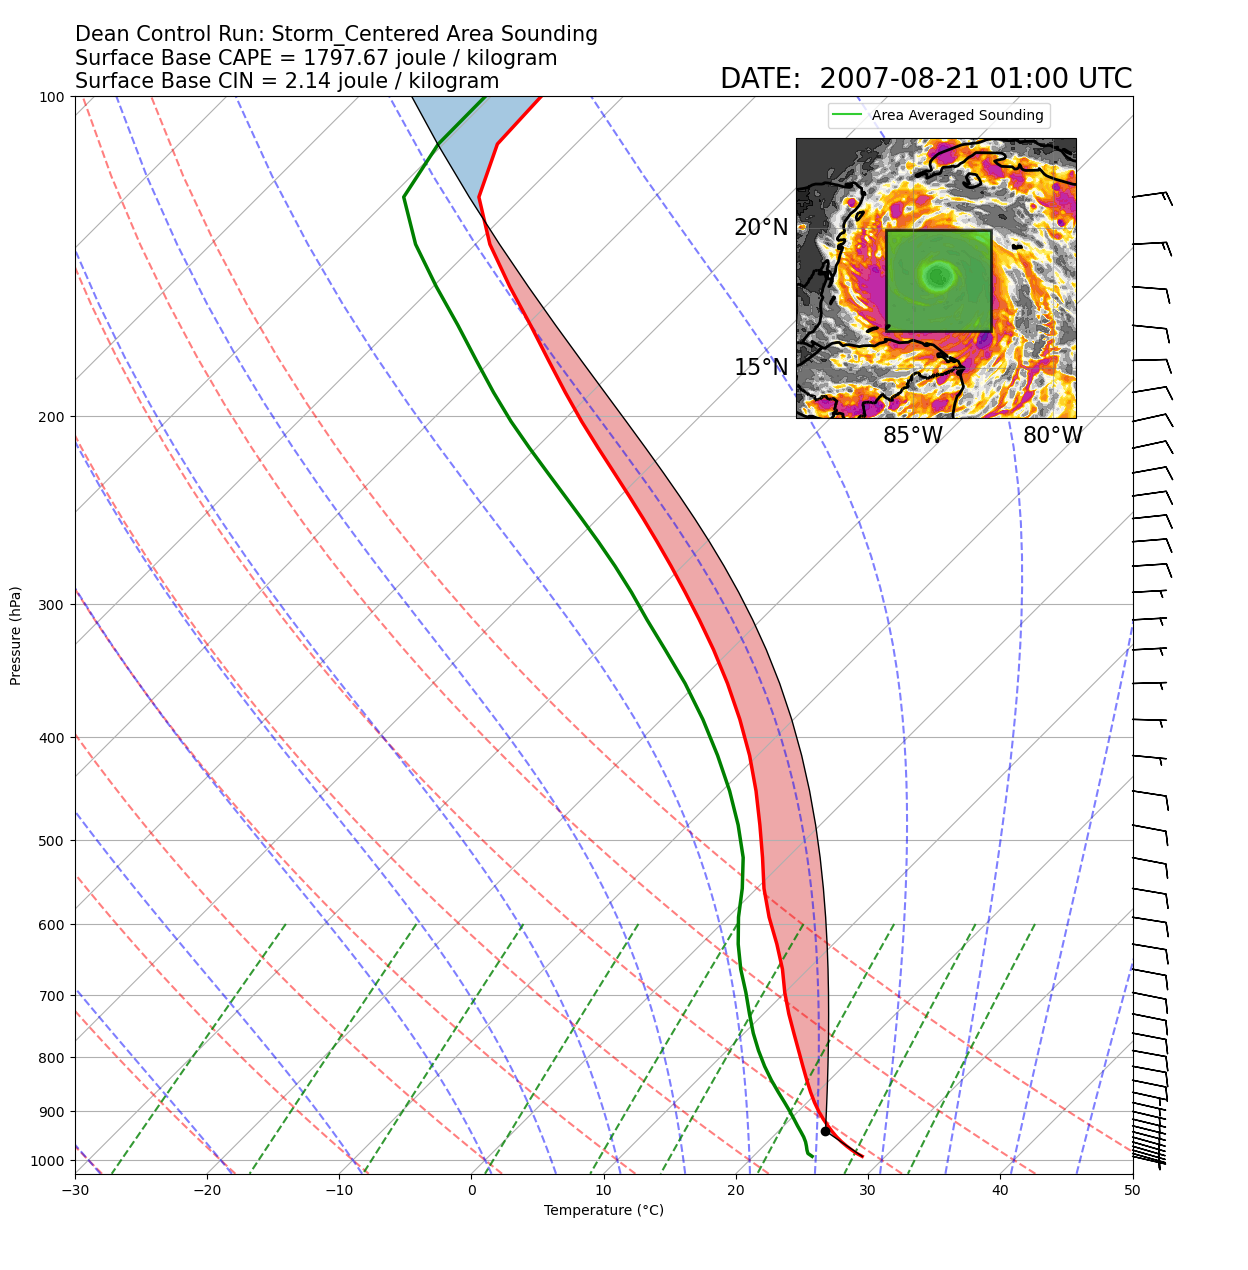

In [9]:
#Now that we have specified that the location of interest is indeed where we want it, 
#we can take an area average sounding!
from metpy.plots import Hodograph

#for i in range(len(Parent_wrfout_unadjusted_d02)):
for i in range(0,1):
    sigma = 5.67 * 10**-8                                                    #Stefon-Boltzman Constant
    
    wrfin = Dataset(Parent_wrfout_unadjusted_d02[i])
    
    wrf_out_data = xr.open_dataset(Parent_wrfout_unadjusted_d02[i])          #Open WRF_Out Data (I sorted glob glob my whole directory)
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_EMISS = wrf_out_data['EMISS'][0,:,:]
    
    wrf_out_OLR_T = ((wrf_out_OLR.values/(wrf_out_EMISS.values * sigma))**(1/4)) - 273.15
    
    #Get pertinent values necessary for skew-T
    p1 = wrf.getvar(wrfin,"pressure",timeidx=0)               #Pressure
    T1 = wrf.getvar(wrfin,"tc",timeidx=0)                     #Temperature
    Td1 = wrf.getvar(wrfin,"td",timeidx=0)                    #Dewpoint
    u1 = wrf.getvar(wrfin,"ua",timeidx=0)                     #Zonal Winds
    v1 = wrf.getvar(wrfin,"va",timeidx=0)                     #Meridional Winds
    pot1 = wrf.getvar(wrfin,"th",timeidx=0)                   #potential Temperature
    height1 = wrf.getvar(wrfin,"height_agl",timeidx=0)        #Height above ground level for mass point
    
    #Now that we are done with our textfile, we want to make a nice skew_T:
    p_area =  (p1[:,int(X_Y_Sounding_Center[i][1]-Extent_of_Box):int(X_Y_Sounding_Center[i][1]+Extent_of_Box),
                 int(X_Y_Sounding_Center[i][0]-Extent_of_Box):int(X_Y_Sounding_Center[i][0]+Extent_of_Box)]   * units.hPa)        #Average Pressure in Hpa 
    
    T_area =  (T1[:,int(X_Y_Sounding_Center[i][1]-Extent_of_Box):int(X_Y_Sounding_Center[i][1]+Extent_of_Box),
                 int(X_Y_Sounding_Center[i][0]-Extent_of_Box):int(X_Y_Sounding_Center[i][0]+Extent_of_Box)]   * units.degC)       #Average Temperature in Degrees Celsius
  
    Td_area = (Td1[:,int(X_Y_Sounding_Center[i][1]-Extent_of_Box):int(X_Y_Sounding_Center[i][1]+Extent_of_Box),
                  int(X_Y_Sounding_Center[i][0]-Extent_of_Box):int(X_Y_Sounding_Center[i][0]+Extent_of_Box)]  * units.degC)       #Average Dewpoint Temperature in Degrees Celsius
   
    u_area =  (u1[:,int(X_Y_Sounding_Center[i][1]-Extent_of_Box):int(X_Y_Sounding_Center[i][1]+Extent_of_Box),
                 int(X_Y_Sounding_Center[i][0]-Extent_of_Box):int(X_Y_Sounding_Center[i][0]+Extent_of_Box)]   * units('m/s'))     #Average Zonal Winds in m/s                  
    
    v_area =  (v1[:,int(X_Y_Sounding_Center[i][1]-Extent_of_Box):int(X_Y_Sounding_Center[i][1]+Extent_of_Box),
                 int(X_Y_Sounding_Center[i][0]-Extent_of_Box):int(X_Y_Sounding_Center[i][0]+Extent_of_Box)]   * units('m/s'))     #Average Meridional winds in m/s
    
    #to take the area average sounding, we need to average (mean) about the S_N and W_E arrays
    p_avg_we = p_area.mean(dim = 'south_north')      #Average out area sounding across the S_n array
    p_avg    = p_avg_we.mean(dim = 'west_east')      #Average our area + S_N average by the W_E so we have a 1d array with pressure levels and values

    #Same for Tempearture
    T_avg_we = T_area.mean(dim = 'south_north')
    T_avg    = T_avg_we.mean(dim = 'west_east')

    #Same For Dewpopint
    Td_avg_we = Td_area.mean(dim = 'south_north')
    Td_avg    = Td_avg_we.mean(dim = 'west_east')

    #Same for zonal wind
    u_avg_we = u_area.mean(dim = 'south_north')
    u_avg    = u_avg_we.mean(dim = 'west_east')

    #Same for meridional wind
    v_avg_we = v_area.mean(dim = 'south_north')
    v_avg    = v_avg_we.mean(dim = 'west_east')
    
    #MetPy skew-T plotting
    fig = plt.figure(figsize = (14,14))
    skew = SkewT(fig, rotation = 45)
    ax1 = skew
    ax1.plot(p_avg, T_avg, 'r', linewidth = 2.5)
    ax1.plot(p_avg, Td_avg, 'g', linewidth = 2.5)
    
    #Specify Range Below for your plot
    ax1.ax.set_ylim(1030,100)
    ax1.ax.set_xlim(-30,50)
    
    #ax1.ax.set_xlim(10,35)
    #ax1.ax.set_ylim(1000,750)
    
    ncfile = Dataset(Parent_wrfout_unadjusted_d02[i])
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr = (str(Time))
    
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])

    lcl_pressure , lcl_temperature = mpcalc.lcl(p_avg[0], T_avg[0], Td_avg[0])
    ax1.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor = 'black')

    #Find LCL Height
    prof = mpcalc.parcel_profile(p_avg, T_avg[0], Td_avg[0]) 
    prof = prof.values - 273.15 
    ax1.plot(p_avg, prof, 'k', linewidth = 1)

    ax1.shade_cin(p_avg.values, T_avg.values, prof) 
    ax1.shade_cape(p_avg.values, T_avg.values, prof)
    
    # calculate surface based CAPE/CIN
    prof = prof * units.degC  
    cape_cin = mpcalc.cape_cin(p_avg, T_avg, Td_avg, prof)

    #Plot Wind Barbs
    ax1.plot_barbs(p_avg[:-5].values, u_avg[:-5], v_avg[:-5])

    #Plot Skew-T
    ax1.plot_dry_adiabats()
    ax1.plot_moist_adiabats()
    ax1.plot_mixing_lines()
    
    ax1.ax.set_xlabel("Temperature (°C)")
    ax1.ax.set_ylabel("Pressure (hPa)")

    plt.title(f'DATE: '+' '+titletime+' UTC', loc = 'right', fontsize = 20)
    plt.title(f'Dean Control Run: Storm_Centered Area Sounding \nSurface Base CAPE = {cape_cin[0]:.2f}\nSurface Base CIN = {-cape_cin[1]:.2f}', loc = 'left', fontsize = 15)

    #Next for valdiation purposes, show the approximate area of the sounding via the code above
    ax2 = fig.add_axes([0.65, 0.65, 0.2, 0.2], projection=ccrs.PlateCarree())  #Specify the location
    #ax2 = fig.add_axes([0.2, 0.4, 0.15, 0.15], projection=ccrs.PlateCarree())  #Specify the location
    tclon5a=5*(int(tc_lon[i]/5)-1)
    tclon5b=5*(int(tc_lon[i]/5))
    tclat5a=5*(int(tc_lat[i]/5)-1)
    tclat5b=5*(int(tc_lat[i]/5))
       
    ax2.set_extent([tc_lon[i]-5, tc_lon[i]+5, tc_lat[i]-5, tc_lat[i]+5],ccrs.PlateCarree()) #Constrain FOV of plot
    ax2.coastlines('50m', linewidth=2, color = 'k')
    ax2.add_feature(cfeature.BORDERS, linewidth=2, color = 'k')
    gl = ax2.gridlines(color='gray',alpha=0.5,draw_labels=True)
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a-10, tclon5a-5, tclon5a, tclon5b, tclon5b+5, tclon5b+10])
    gl.ylocator = mticker.FixedLocator([tclat5a-10, tclat5a-5, tclat5a, tclat5b, tclat5b+5, tclat5b+10])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(gl.xformatter)
    ax2.yaxis.set_major_formatter(gl.yformatter)

    #Plot for ax2
    ax2.contourf(wrf_out_data['XLONG'][0,:,:].values, wrf_out_data['XLAT'][0,:,:].values, wrf_out_OLR_T,
            origin = 'lower', cmap = newcmp, levels = np.arange(-80, 5, 5), alpha = .85, extend ='both')

    #For Sounding Location
    lon_i = wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1],X_Y_Sounding_Center[i][0]].values
    lat_i = wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1],X_Y_Sounding_Center[i][0]].values
    
    ax2.plot(lon_i, lat_i, color = 'limegreen', label = "Area Averaged Sounding")

    #Add square for where we are attempting to take an area average sounding!
    #bottom Left Point of Square:
    bottom_left = (wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values, 
                  wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values)
        
    width = (wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]+Extent_of_Box].values - 
            wrf_out_data['XLONG'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values)
    
    height = (wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1]+Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values - 
             wrf_out_data['XLAT'][0,X_Y_Sounding_Center[i][1]-Extent_of_Box, X_Y_Sounding_Center[i][0]-Extent_of_Box].values)
    
    ax2.add_patch(Rectangle((bottom_left), #bottom left point of square
                 width,                   #Width
                 height,                  #height
                 edgecolor = 'black',
                 facecolor = 'limegreen',
                 fill= True, alpha = .75,
                 lw=2))

    plt.legend(bbox_to_anchor=(.43, .65, 0.5, 0.5))

    plt.show()
    plt.close()
